In [137]:
# Import libraries and initialize global variables
import utils
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
Start_date = utils.date_range()[0]
End_date = utils.date_range()[1]
import datetime 
  
def convert2hours(n): 
    return str(datetime.timedelta(seconds = n)) 

In [2]:
# Pick start date
Start_date

DatePicker(value=datetime.date(2020, 9, 22), description='Start Date')

In [3]:
# Pick end date
End_date

DatePicker(value=datetime.datetime(2021, 2, 2, 10, 56, 0, 253951), description='End Date')

In [101]:
%%time
# database response stored in pandas dataframe
df = utils.db_connect(pem_file='centos.pem',
                      start_date=Start_date.value.strftime("%Y-%m-%d"),
                      end_date=End_date.value.strftime("%Y-%m-%d"))

CPU times: user 13.3 s, sys: 4.17 s, total: 17.4 s
Wall time: 14min 10s


In [102]:
df.tail()

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus
335545,335546,1,505,2021-02-02 18:42:38,CC50E304FA9A,0.32,216,48.35,on
335546,335547,1,505,2021-02-02 18:42:55,CC50E3DA533F,0.5,210,95.68,on
335547,335548,1,505,2021-02-02 18:43:08,CC50E304FA9A,0.33,207,47.39,on
335548,335549,1,505,2021-02-02 18:43:25,CC50E3DA533F,0.5,207,95.65,on
335549,335550,1,505,2021-02-02 18:43:38,CC50E304FA9A,0.33,212,48.88,on


In [390]:
# Number of unique mac ids
df.mac.nunique()

100

In [381]:
# Change column types to numeric
df[["current","voltage", "power"]] = df[["current","voltage", "power"]].apply(pd.to_numeric)

In [382]:
df.dtypes

id                       int64
status                   int64
userid                   int64
timestamp       datetime64[ns]
mac                     object
current                float64
voltage                  int64
power                  float64
devicestatus            object
dtype: object

In [383]:
# Filter the datasets
start_date = '2020-12-16'
end_date = '2020-12-17'
date_mask = (df['timestamp'] > start_date ) & (df['timestamp'] <= end_date)
df_with_mask = df.loc[date_mask]
df_mac1 = df_with_mask[df_with_mask['mac'].isin(["CC50E3DA533F"])]
df_mac2 = df_with_mask[df_with_mask['mac'].isin(["CC50E304FADC"])]
df_mac3 = df_with_mask[df_with_mask['mac'].isin(["CC50E3DA533F","CC50E304FADC","CC50E304FA9A"])]
# df_mac1[df_mac1['devicestatus']=='off']

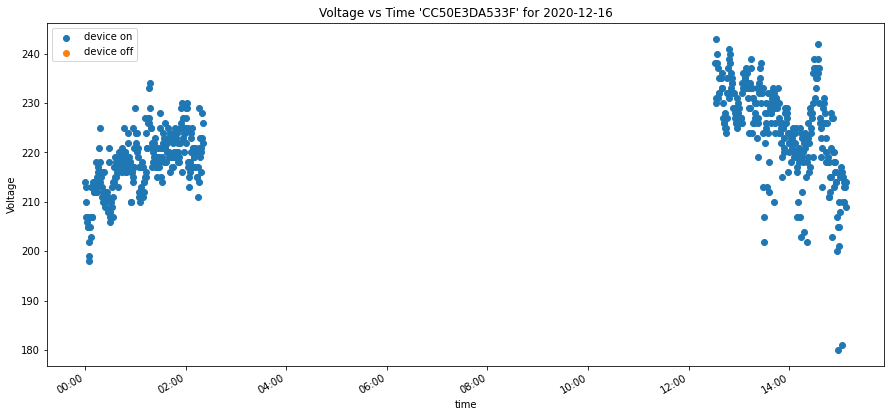

In [23]:
# Plot for Voltage vs Time CC50E3DA533F
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
plt.scatter(on["timestamp"], on["voltage"], label='device on')
plt.scatter(off["timestamp"], off["voltage"], label='device off')

plt.title(f'Voltage vs Time \'CC50E3DA533F\' for {start_date}')
plt.xlabel('time')
plt.ylabel('Voltage')
plt.legend()



myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.show()

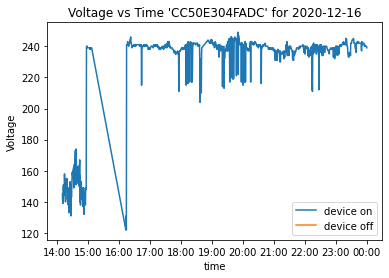

In [384]:
# Plot for Voltage vs Time CC50E304FADC
plt.figure()
on = df_mac2[df_mac2['devicestatus']=='on']
off = df_mac2[df_mac2['devicestatus']=='off']
plt.plot(on["timestamp"], on["voltage"], label='device on')
plt.plot(off["timestamp"], off["voltage"], label='device off')
plt.title(f'Voltage vs Time \'CC50E304FADC\' for {start_date}')
plt.xlabel('time')
plt.ylabel('Voltage')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

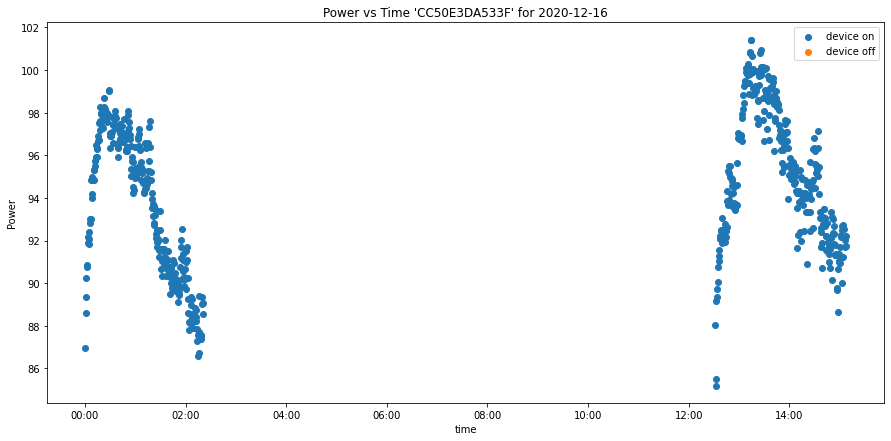

In [124]:
# Plot for Power vs Time CC50E3DA533F
plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
plt.scatter(on["timestamp"], on["power"], label='device on')
plt.scatter(off["timestamp"], off["power"], label='device off')
plt.title(f'Power vs Time \'CC50E3DA533F\' for {start_date}')
plt.xlabel('time')
plt.ylabel('Power')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

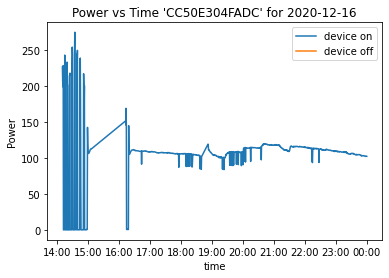

In [125]:
# Plot for Power vs Time CC50E304FADC
plt.figure()
on = df_mac2[df_mac2['devicestatus']=='on']
off = df_mac2[df_mac2['devicestatus']=='off']
plt.plot(on["timestamp"], on["power"], label='device on')
plt.plot(off["timestamp"], off["power"], label='device off')
plt.title(f'Power vs Time \'CC50E304FADC\' for {start_date}')
plt.xlabel('time')
plt.ylabel('Power')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

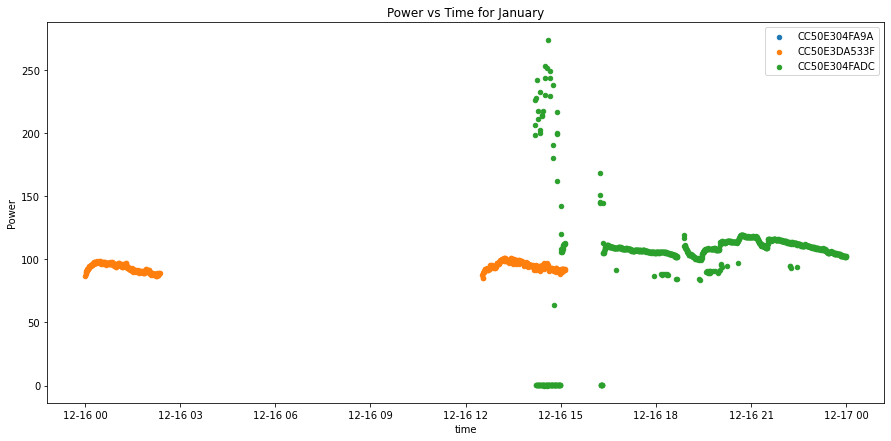

In [385]:
# Plot for Power vs Time 
plt.figure(figsize=(15,7))
CC50E304FA9A = df_mac3[df_mac3['mac']=='CC50E304FA9A']
CC50E3DA533F = df_mac3[df_mac3['mac']=='CC50E3DA533F']
CC50E304FADC = df_mac3[df_mac3['mac']=='CC50E304FADC']
mark_size = 20
plt.scatter(CC50E304FA9A["timestamp"], CC50E304FA9A["power"], label='CC50E304FA9A', s =mark_size)
plt.scatter(CC50E3DA533F["timestamp"], CC50E3DA533F["power"], label='CC50E3DA533F', s =mark_size)
plt.scatter(CC50E304FADC["timestamp"], CC50E304FADC["power"], label='CC50E304FADC', s =mark_size)

plt.title(f'Power vs Time for January')
plt.xlabel('time')
plt.ylabel('Power')
plt.legend()
# myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
# plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

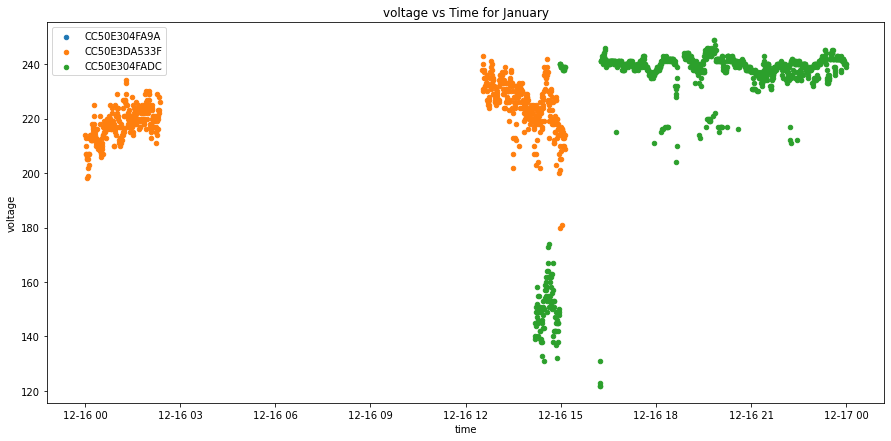

In [387]:
# Plot for Voltage vs Time 
plt.figure(figsize=(15,7))
CC50E304FA9A = df_mac3[df_mac3['mac']=='CC50E304FA9A']
CC50E3DA533F = df_mac3[df_mac3['mac']=='CC50E3DA533F']
CC50E304FADC = df_mac3[df_mac3['mac']=='CC50E304FADC']
mark_size = 20
plt.scatter(CC50E304FA9A["timestamp"], CC50E304FA9A["voltage"], label='CC50E304FA9A', s =mark_size)
plt.scatter(CC50E3DA533F["timestamp"], CC50E3DA533F["voltage"], label='CC50E3DA533F', s =mark_size)
plt.scatter(CC50E304FADC["timestamp"], CC50E304FADC["voltage"], label='CC50E304FADC', s =mark_size)

plt.title(f'voltage vs Time for January')
plt.xlabel('time')
plt.ylabel('voltage')
plt.legend()
# myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
# plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [352]:
## groupby mac addresses
df_grouped_mac = df.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
df_grouped_mac['duration'] = df_grouped_mac.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as do data received
df_grouped_mac.loc[df_grouped_mac['duration'] >=60, 'devicestatus'] = 'no_data_received' 

In [388]:
## Apply filters
mac_address = ['CC50E3DA533F','CC50E304FADC'] # select these mac addresses
date = ['2020-09-23'] # select these dates
tmp = df_grouped_mac.groupby(['mac','date','devicestatus'])['duration'].sum().reset_index()
tmp['duration_in_hours'] = tmp['duration'].apply(convert2hours)
tmp[tmp['mac'].isin(mac_address) & tmp['date'].isin(date)]

,mac,date,devicestatus,duration,duration_in_hours
773,CC50E304FADC,2020-09-23,no_data_received,2854.0,0:47:34
774,CC50E304FADC,2020-09-23,on,41354.0,11:29:14
896,CC50E3DA533F,2020-09-23,no_data_received,5684.0,1:34:44
897,CC50E3DA533F,2020-09-23,off,238.0,0:03:58
898,CC50E3DA533F,2020-09-23,on,80441.0,22:20:41
